# Gravity Model

Everyone wants to see the map first, so here it is. In this article we will automate some of the analysis done in Alon Levy's [Streaming High-Speed Rail Crayoning](https://pedestrianobservations.com/2021/03/20/streaming-high-speed-rail-crayoning/). Mostly we will focus on the Gravity Model which is explained below.

Note: this notebook has been updated to use population-weighted centroids (instead of geometric centroids) for the Combined Statistical Areas (CSA) and a multi-index for the CSA DataFrame.

![gravity_model.png](gravity_model.png)

First we will import the libraries necessary for gathering data, performing our analysis, and plotting the results.

In [28]:
import contextily as ctx
import folium
import geopandas
from numpy import inf
import pandas
from shapely.geometry import LineString
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

from dpd.modeling import DistanceDataFrame, TripDataFrame

pandas.set_option("display.max_columns", None)
pandas.set_option("display.max_rows", None)

Thanks to [Kevin Wilson](https://github.com/khwilson) for creating a geojson file of population-weighted Combined Statistical Areas (CSA) and their corresponding populations. We can easily load this file directly as a GeoPandas GeoDataFrame.

In [2]:
csa = geopandas.read_file(
    "https://gist.githubusercontent.com/khwilson/2df2f86bc444d020b59a9ebe61b7944b/raw/4611d5a54dc976a17a6429e1a1d5deb628861069/csa_population_weighted_centroids.geojson"
)
csa.head()

,csa_fp,csa_name,population,geometry
0,104,"Albany-Schenectady, NY",1170877,POINT (-73.83270 42.84156)
1,106,"Albuquerque-Santa Fe-Las Vegas, NM",1149189,POINT (-106.48704 35.24134)
2,107,"Altoona-Huntingdon, PA",169263,POINT (-78.27657 40.47080)
3,108,"Amarillo-Pampa-Borger, TX",308553,POINT (-101.75521 35.23698)
4,118,"Appleton-Oshkosh-Neenah, WI",404487,POINT (-88.44143 44.20267)


We can use Folium to plot the CSAs on OpenStreetMap. Some cities like San Diego and Tampa are missing because they are outside a CSA. Note that we now use population-weighted centroids for each CSA.

In [24]:
style_function = lambda x: {"radius": x["properties"]["population"]/1000000}
csa.explore(style_kwds={"style_function": style_function})

In the next step, we will implenent our Gravity Model and use it to predict the ridership between all CSAs. The Gravity Model for our analysis is

$ Annual\ Traffic\ Volume = G \times \frac{(Origin\ population)^{a}\ \times\ (Destination\ population)^{b}}{(Distance\ between\ origin\ and\ destination)^{d}} $

In the case of high speed rail, G=75,000, a=b=0.8, and d=2. Also, if the distance is less than 500km, we set distance to 500km. (These numbers are all from the article [Metcalfe’s Law for High-Speed Rail](https://pedestrianobservations.com/2020/02/13/metcalfes-law-for-high-speed-rail/)). The results of this step is a table with the predicted ridership between CSAs. I've dropped rows/columns where the predicted ridership is below 1 million people/year.

In [12]:
distance_dataframe = (
    DistanceDataFrame.from_origins_destinations(
        origins=csa.geometry, destinations=csa.geometry, method="haversine"
    )
    / 1000
)
distance_dataframe = distance_dataframe.where(distance_dataframe != 0, inf)
distance_dataframe = distance_dataframe.where(distance_dataframe >= 500, 500)

trip_dataframe = TripDataFrame.from_gravity_model(
    csa.population / 1000000,
    csa.population / 1000000,
    distance_dataframe,
    G=75000,
    a=0.8,
    b=0.8,
    d=2,
)
trip_dataframe.index = csa.csa_name
trip_dataframe.columns = csa.csa_name
series = trip_dataframe.stack().astype(int)
series.name = "Millions of Annual Passengers"
series = series[series > 0]
pandas.DataFrame(series)

Millions of Annual Passengers
csa_name                                           csa_name                                                                         
Albany-Schenectady, NY                             Boston-Worcester-Providence, MA-RI-NH-CT                                        1
                                                   New York-Newark, NY-NJ-CT-PA                                                    4
                                                   Philadelphia-Reading-Camden, PA-NJ-DE-MD                                        1
                                                   Washington-Baltimore-Arlington, DC-MD-VA-WV-PA                                  2
Atlanta--Athens-Clarke County--Sandy Springs, G... Birmingham-Hoover-Talladega, AL                                                 1
                                                   Charlotte-Concord, NC-SC                                                        2
                                                   Chattanooga-Cleveland-Dalton, TN-GA                                             1
                                                   Chicago-Naperville, IL-IN-WI                                                    2
                                                   Cincinnati-Wilmington-Maysville, OH-KY-IN                                       1
                                                   Cleveland-Akron-Canton, OH                                                      1
                                                   Columbia-Orangeburg-Newberry, SC                                                1
                                                   Columbus-Marion-Zanesville, OH                                                  1
                                                   Dallas-Fort Worth, TX-OK                                                        1
                                                   Detroit-Warren-Ann Arbor, MI                                                    1
                                                   Fayetteville-Sanford-Lumberton, NC                                              1
                                                   Greensboro--Winston-Salem--High Point, NC                                       2
                                                   Greenville-Spartanburg-Anderson, SC                                             1
                                                   Houston-The Woodlands, TX                                                       1
                                                   Indianapolis-Carmel-Muncie, IN                                                  1
                                                   Jacksonville-St. Marys-Palatka, FL-GA                                           1
                                                   Knoxville-Morristown-Sevierville, TN                                            1
                                                   Lexington-Fayette--Richmond--Frankfort, KY                                      1
                                                   Louisville/Jefferson County--Elizabethtown--Bar...                              1
                                                   Memphis-Forrest City, TN-MS-AR                                                  1
                                                   Miami-Port St. Lucie-Fort Lauderdale, FL                                        1
                                                   Nashville-Davidson--Murfreesboro, TN                                            2
                                                   New York-Newark, NY-NJ-CT-PA                                                    2
                                                   Orlando-Lakeland-Deltona, FL                                                    2
                                                   Philadelphia-Reading-Camden, PA-NJ-DE-MD                      

Now we can plot these city pairs on a map. We will limit this plot to pairs with ridership potential above 2 million people/year. Line width is based on ridership potential. This map looks very famaliar to Alon Levy's map. California, Texas, Florida, the Midwest, and the Northeast Corridor all have strong potential for high-speed rail. There is not a strong potential for cross-country high-speed rail. Note that this analysis ignores many factors such as geography, cost, cooperation between routes, and cultural/societal factors. It also ignores international routes.

In [13]:
series = series[series > 1]
linestrings = []
for origin, destination in series.index:
    linestrings.append(
        {
            "geometry": LineString(
                [
                    csa[csa["csa_name"] == origin]["geometry"].iloc[0],
                    csa[csa["csa_name"] == destination]["geometry"].iloc[0],
                ]
            ),
            "passengers": series[origin][destination],
        }
    )
routes = geopandas.GeoDataFrame(linestrings)
routes.crs = csa.crs

In [27]:
style_function = lambda x: {"weight": x["properties"]["passengers"]}
m = routes.explore(style_kwds={"style_function": style_function})

style_function = lambda x: {"radius": x["properties"]["population"]/1000000}
csa.explore(m = m, style_kwds={"style_function": style_function})

Last we can also plot the map as a png.

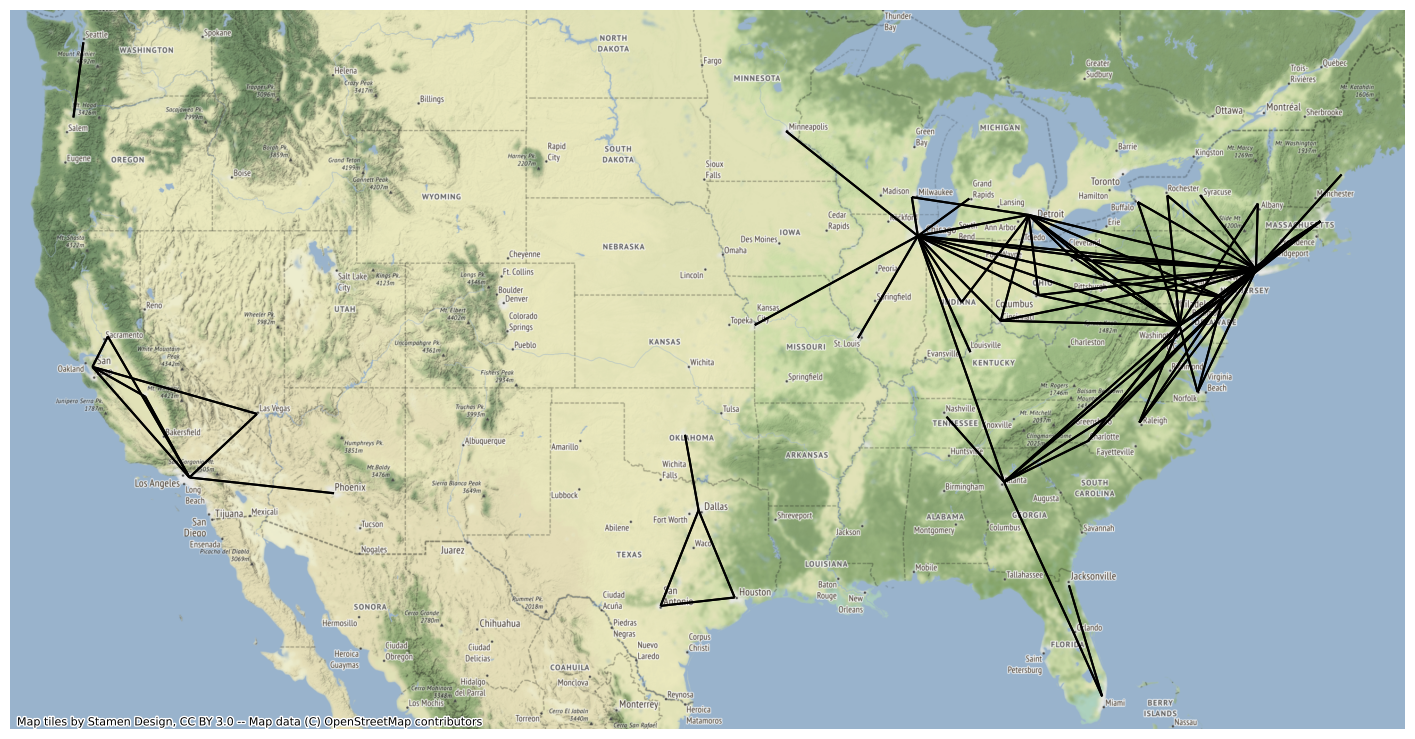

In [7]:
routes.to_crs(epsg=3857, inplace=True)
ax = routes.plot(figsize=(18, 10), color="black")
ctx.add_basemap(ax, zoom=6)
ax.set_axis_off()
fig = ax.get_figure()
fig.savefig("gravity_model.png")

Below is my previous code for getting the list of Combined Statistical Areas (CSA) with their 2019 populations from Wikipedia. I also computed the geometric centroid of each CSA based on data from the United States Census Bureau. I then combined these two tables to create a table with both population and geometry. This has been replaced by [Kevin Wilson](https://github.com/khwilson)'s file above.

In [2]:
from dpd.wikipedia import get_wikipedia_table
from dpd.utils import download_file

rl = "https://en.wikipedia.org/wiki/Combined_statistical_area"
wikipeida_csa = get_wikipedia_table(url, 1)
wikipeida_csa["Combined\xa0statistical\xa0area"] = wikipeida_csa[
    "Combined\xa0statistical\xa0area"
].map(lambda x: x.replace("Combined Statistical Area", "CSA"))
wikipeida_csa["2019 estimate"] = wikipeida_csa["2019 estimate"].map(
    lambda x: int(x.replace(",", ""))
)

url = "https://www2.census.gov/geo/tiger/TIGER2020/CSA/tl_2020_us_csa.zip"
tiger_file = download_file(url)
tiger = geopandas.GeoDataFrame.from_file(tiger_file)
tiger["NAMELSAD"] = tiger["NAMELSAD"].map(lambda x: x.replace("--", "–"))
tiger["geometry"] = tiger["geometry"].map(lambda x: x.centroid)

csa = pandas.merge(
    tiger,
    wikipeida_csa,
    left_on="NAMELSAD",
    right_on="Combined\xa0statistical\xa0area",
    how="inner",
)
csa.head()

,CSAFP,GEOID,NAME,NAMELSAD,LSAD,MTFCC,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Rank,Combined statistical area,2019 estimate,2010 Census,Change,Constituent core-based statistical areas
0,104,104,"Albany-Schenectady, NY","Albany-Schenectady, NY CSA",M0,G3100,15652232590,527824982,+42.9540614,-073.9005139,POINT (-73.89981 42.95639),49,"Albany-Schenectady, NY CSA",1167594,"1,168,485",−0.08%,"Albany-Schenectady-Troy, NY Metropolitan Stati..."
1,106,106,"Albuquerque-Santa Fe-Las Vegas, NM","Albuquerque-Santa Fe-Las Vegas, NM CSA",M0,G3100,61671595463,183599612,+35.6438233,-106.0299689,POINT (-106.03469 35.64568),51,"Albuquerque-Santa Fe-Las Vegas, NM CSA",1158464,"1,123,717",+3.09%,"Albuquerque, NM Metropolitan Statistical AreaS..."
2,107,107,"Altoona-Huntingdon, PA","Altoona-Huntingdon, PA CSA",M0,G3100,3625795409,41146759,+40.4391336,-078.1133892,POINT (-78.11784 40.44081),145,"Altoona-Huntingdon, PA CSA",166973,"173,002",−3.48%,"Altoona, PA Metropolitan Statistical AreaHunti..."
3,108,108,"Amarillo-Pampa-Borger, TX","Amarillo-Pampa-Borger, TX CSA",M0,G3100,20430948210,113498376,+35.3963177,-101.5947616,POINT (-101.58970 35.40284),107,"Amarillo-Pampa-Borger, TX CSA",308731,"297,547",+3.76%,"Amarillo, TX Metropolitan Statistical AreaPamp..."
4,118,118,"Appleton-Oshkosh-Neenah, WI","Appleton-Oshkosh-Neenah, WI CSA",M0,G3100,3601389268,595054344,+44.2906032,-088.3723255,POINT (-88.46859 44.21060),98,"Appleton-Oshkosh-Neenah, WI CSA",409881,"392,660",+4.39%,"Appleton, WI Metropolitan Statistical AreaOshk..."
